In [46]:
import Construct_H_0 as ConstructionSite
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize as opt
import Fitting_to_Sinus as BobRoss
import os
import importlib
import Plot_BBG
import matplotlib.patches as mpatches
importlib.reload(BobRoss)
importlib.reload(ConstructionSite)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpat
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
matplotlib.rcParams['text.usetex'] = True
import Filling_of_mu_BBG as SexiFermiPlots
importlib.reload(SexiFermiPlots)
importlib.reload(Plot_BBG)
from matplotlib.colors import ListedColormap,to_rgba

###We import all important libraries, including our own pre-written ones

In [47]:
plt.rcParams.update({
"text.usetex": True,
"font.family": "Helvetica"
})    

#We want Latex for the figures

In [48]:
np.set_printoptions(threshold=sys.maxsize,suppress=True)

def R_x(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])
  
def R_y(theta):
    return np.matrix([[ np.cos(theta), 0, np.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-np.sin(theta), 0, np.cos(theta)]])
  
def R_z(theta):
    return np.matrix([[ np.cos(theta), -np.sin(theta), 0 ],
                   [ np.sin(theta), np.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

#We define rotation matrices for later

In [4]:
##We define our data set we want to analyze. The provided example data set is the data from
#The 12 x 12 calculations we use in our paper and refers to BBG

N_x = 12
N_y = 12
N_tot = N_x*N_y
U = 3.0
Periodic_Boundaries_x = True
Periodic_Boundaries_y = True

#We define the sampled values of T, Doping and the 4 different atoms that are in the unit cell

T_Array = [0.0,0.01, 0.02,0.03, 0.04,0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5]
Atom_Array = [0.,1.,2.,3.]
Doping_Array = np.arange(0.5,-0.5,-1./144)
Displacement_Field = 0.

GapVectorArray = np.load("GapVectorArrayBBG.npy")

In [5]:
###The next few cells are just helping to later classify our spin orders

x_frequencies = np.fft.rfftfreq(N_x)
y_frequencies = np.fft.fftfreq(N_y)

Indexlist = []
FrequencyList_Diag = []
for x in range(len(x_frequencies)):
    for y in range(len(y_frequencies)):
        if(np.isclose(x_frequencies[x],y_frequencies[y]) or np.isclose(x_frequencies[x],-y_frequencies[y])):
            Indexlist.append(np.array([x,y]))
            FrequencyList_Diag.append(y_frequencies[y])
Indices = np.array(Indexlist)
FrequencyList_Diag = np.array(FrequencyList_Diag)

x_Diagonals = Indices[:,0]
y_Diagonals = Indices[:,1]

In [6]:
P1 = np.array([-2/np.sqrt(3),2])*np.pi/np.sqrt(3)
P2 = np.array([2/np.sqrt(3),2])*np.pi/np.sqrt(3)
P3 = np.array([4/np.sqrt(3),0])*np.pi/np.sqrt(3)
P4 = np.array([2/np.sqrt(3),-2])*np.pi/np.sqrt(3)
P5 = np.array([-2/np.sqrt(3),-2])*np.pi/np.sqrt(3)
P6 = np.array([-4/np.sqrt(3),0])*np.pi/np.sqrt(3)

M1 = (P1 + P2)/2
M2 = (P2 + P3)/2
M3 = (P3 + P4)/2
M4 = (P4 + P5)/2
M5 = (P5 + P6)/2
M6 = (P6 + P1)/2

MPoints = [M1,M2,M3,M4,M5,M6]
KPoints = [P1,P2,P3,P4,P5,P6]

MPoints = np.array(MPoints)
KPoints = np.array(KPoints)

In [7]:
def mirror(origin, point):

    ox, oy = origin
    px, py = point

    qx = ox - (px - ox)
    qy = oy - (py - oy)
    return qx, qy

In [8]:
def GetGoodIndices(N_x):
    
    #This function is used to sample only half of the Brillouin zone to avoid double counting Q and -Q 
    #as 2 seperate wavevectors.
    
    N_tot = N_x*N_x
    Qs,Components = Plot_BBG.Plotit(np.random.random(4*N_tot),returnaxes=True,N_x = N_x,Quickreturn = True)
    Qs = Qs.reshape(2,N_tot)
    Components = (Components.reshape(N_tot,3)).transpose()

    Badindices = []
    for i in range(len(Qs[0,:])):

        if(i in Badindices):
            continue

        Q_Test = -Qs[:,i]
        C1 = np.where((np.isclose(Qs.transpose(),Q_Test))[:,0]*(np.isclose(Qs.transpose(),Q_Test))[:,1])
        if(len(C1[0])==1):

            if(C1[0][0]!= 0):
                Badindices.append(C1[0][0])
        else:

            Q_Test = Qs[:,i]
            C1 = np.where(np.isclose(KPoints,Q_Test)[:,0]*np.isclose(KPoints,Q_Test)[:,1])
            if(len(C1[0])==1):
                continue

            C1 = np.where(np.isclose(MPoints,Q_Test)[:,0]*np.isclose(MPoints,Q_Test)[:,1])
            if(len(C1[0])==1):
                continue

            for M in MPoints:
                Q_Test = mirror(M,Qs[:,i])
                C1 = np.where((np.isclose(Qs.transpose(),Q_Test))[:,0]*(np.isclose(Qs.transpose(),Q_Test))[:,1])
                if(len(C1[0])==1):
                    Badindices.append(C1[0][0])


    Indices = np.array(range(len(Qs[0])))
    GoodIndices = []
    for i in Indices:
        if(i not in Badindices):
            GoodIndices.append(i)
            
    return GoodIndices

GoodIndices = np.array(GetGoodIndices(N_x))

In [50]:
def Classification(Gappy,ReturnVecs = False,N_x = N_x,GetIndices = False):
    
    #This routine classifies a given GapVector according to the scheme presented in the paper.
    
    N_tot = N_x*N_x
    if(GetIndices == True):
        NewGoodIndices = GetGoodIndices(N_x)
    else:
        NewGoodIndices = GoodIndices
    
    Qs,Components= Plot_BBG.Plotit(Gappy,Quickreturn=True,N_x = N_x)

    Qs = Qs.reshape(2,N_tot)
    Components = (Components.reshape(N_tot,3)).transpose()

    Components = Components[:,NewGoodIndices]
    Qs = Qs[:,NewGoodIndices]
    Amplitude = np.linalg.norm(Components,axis = 0)

    ind = np.argpartition(Amplitude, -8)[-8:]
    ind = ind[np.argsort(Amplitude[ind])][::-1]

    TotalNorm = np.linalg.norm(Amplitude)
    CurrentNorm = 0.
    relevantind = []

    for i in ind:
        CurrentNorm = np.sqrt(CurrentNorm**2 + Amplitude[i]**2)
        relevantind.append(i)
        if(CurrentNorm>=0.87*TotalNorm):
            break
    ###Filter k <-> -k raus      
    if(len(relevantind) == 1):
        
        if(ReturnVecs ==True):
            return Components[:,ind[0]]
        
        ind = relevantind[0]

        if(ind == 0):
            return "Ferro"
        
        Q_curr = Qs[:,ind]

        RealVec = np.real(Components[:,ind])
        ImVec = np.imag(Components[:,ind])

        Ratio = (np.abs(RealVec@ImVec)/(np.linalg.norm(RealVec)*np.linalg.norm(ImVec)))
        if(0.9<Ratio<=1.000005):
            return "Stripe"
        
        if(Ratio<0.1):
            return "Spiral"
        return "Elliptical"

    if(len(relevantind) == 2):
        ##Nähe zu K überprüfen, damit nicht falsch.
        if(ReturnVecs ==True):
            return Components[:,ind[0]],Components[:,ind[1]]
        
        V1 = Components[:,ind[0]]
        V2 = Components[:,ind[1]]
        

        
            
        if(np.abs(V1@V1)/np.linalg.norm(V1)**2>0.95 and np.abs(V2@V2)/np.linalg.norm(V2)**2>0.95):
            if(np.abs(V1@V2.conjugate())/np.linalg.norm(V2)**2<0.01 and np.abs(V1@V2)/np.linalg.norm(V2)**2<0.01):
                return "2 orth Stripes"

        if(np.abs(V1@V1)/np.linalg.norm(V1)**2<0.05 and np.abs(V2@V2)/np.linalg.norm(V2)**2<0.05):
            if(np.abs(V1@V2.conjugate())/np.linalg.norm(V2)**2<0.01 and np.abs(V1@V2)/np.linalg.norm(V2)**2>0.95):
                return "2 orth Spirals"            
            
            
        return "Zweierlei"
    
    if(len(relevantind) == 3):
        V1 = Components[:,ind[0]]
        V2 = Components[:,ind[1]]
        V3 = Components[:,ind[2]]
        

            
        if(ReturnVecs==True):
            return V1,V2,V3
        
        if(np.abs(V1.conjugate()@V2)/(np.linalg.norm(V1)*np.linalg.norm(V2))>0.9 and np.abs(V1.conjugate()@V3)/(np.linalg.norm(V1)*np.linalg.norm(V3))>0.9 and np.abs(V3.conjugate()@V2)/(np.linalg.norm(V3)*np.linalg.norm(V2))>0.9):
            return "3ParallelStripes"
        ##Nähe zu K überprüfen, damit nicht falsch.
        if(Amplitude[relevantind[0]]/ Amplitude[relevantind[1]]<1.1 and Amplitude[relevantind[1]]/ Amplitude[relevantind[2]]<1.1):
            
            ind = relevantind
            #print(ind)
            Ratio = np.abs(V1@np.cross(V2,V3))/(np.linalg.norm(V1)*np.linalg.norm(V2)*np.linalg.norm(V3))
            if(ReturnVecs==True):
                return V1,V2,V3
            #print(V1,V2,V3)
            if(Ratio>0.95):
                return "ThreeStripes"
            

            
            #H_x = 1.*V1
            #H_x = np.exp(-1j*np.angle(H_x[0]))*H_x
            
            
            #RotMat = R_y(-np.arccos(np.real(H_x[0])/np.linalg.norm(np.real(H_x))))@R_x(np.arctan(np.real(H_x[1])/np.real(H_x[2]+10**-10)))
            #H_x_test = np.array(RotMat@H_x)[0]
            
            #print(RotMat@V1*np.exp(-1j*np.angle(V1[0])),"V1")
            #print()
            #print(RotMat@V2*np.exp(-1j*np.angle(V2[0])),"V2")
            #print()
            #print(RotMat@V3*np.exp(-1j*np.angle(V3[0])),"V3")
            return "ThreeOfAKind"
        
        return "Dreierlei"
        
    if(len(relevantind) > 3):
        return "Gewusel"

    return "WTF"

    

In [14]:
###Here we classify each GapVector by the criteria we pointed out in the paper. As a "Progress-Bar", we print 
###the currently processed temperature. For our sample data, the highes temperature is 0.5t and it might take
###a few minutes until each state is properly classified.

ClassArray = np.zeros((len(T_Array),len(Atom_Array),len(Doping_Array)),dtype = object)

for i in range(len(T_Array)):
    print(T_Array[i])
    for j in range(4):
        for k in range(len(Doping_Array)):
            
            GapVector = GapVectorArray[i,j,k]
            ClassArray[i,j,k] = Classification(GapVector)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [20]:
BobRoss.Set_Params(N_x,N_y)

In [21]:
def CollinearOrder(GapVector):
    #In case the user wants to distinguish general strange order from collinear order.
    #This function will return True if all spins are collinear and otherwise False
    
    S_x,S_y,S_z = BobRoss.PlotMagn(GapVector,QuickReturn = True)
    if(np.linalg.norm(S_y)/N_tot<0.001 and np.linalg.norm(S_z)/N_tot<0.001):
        return True
    return False

In [22]:
Norm = np.zeros((len(T_Array),len(Atom_Array),len(Doping_Array)))

for i in range(len(T_Array)):
    for j in range(len(Atom_Array)):
        for k in range(len(Doping_Array)):
            GapVector = GapVectorArray[i,j,k]
            N_ups = GapVector[:N_tot]
            N_downs = GapVector[N_tot:2*N_tot]
            D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:]
            S_x = 2*np.real(D_UpDowns)
            S_y = 2*np.imag(D_UpDowns)
            S_z = N_ups-N_downs

            Charge_local = GapVectorArray[i,j,k][:N_tot] + GapVectorArray[i,j,k][N_tot:2*N_tot]
            Amplitudes = np.sqrt(S_x**2 + S_y**2 +S_z**2)
            Norm[i,j,k] = 1./N_tot*np.sum(Amplitudes)
            if(Norm[i,j,k]<0.001):
                ClassArray[i,j,k] = "Para"
                
            #In case the user wants to distinguish general strange order from collinear order.
            if(CollinearOrder(GapVector)==True):
                if(ClassArray[i,j,k]!="Para" and ClassArray[i,j,k]!= "Stripe" and ClassArray[i,j,k] !="Ferro" and ClassArray[i,j,k] !="3ParallelStripes"):
                    ClassArray[i,j,k] = "Collinear"


In [24]:
#Here we colorcode the different phases into different categories

ColorArrayPlot = np.zeros(ClassArray.shape)
for i in range(len(T_Array)):
    for j in range(len(Atom_Array)):
        for k in range(len(Doping_Array)):
            if(ClassArray[i,j,k] == "Ferro"):
                if(k>=20):
                    ColorArrayPlot[i,j,k] = 2.
                else:
                    ColorArrayPlot[i,j,k] = 0

            if(ClassArray[i,j,k] == "Stripe"):
                ColorArrayPlot[i,j,k] = 4.
            if(ClassArray[i,j,k] == "Spiral" or ClassArray[i,j,k] == "ELL"):
                ColorArrayPlot[i,j,k] = 0.    
            if(ClassArray[i,j,k] == "Zweierlei"):
                ColorArrayPlot[i,j,k] = 7
            if(ClassArray[i,j,k] == "Dreierlei"):
                ColorArrayPlot[i,j,k] = 0
            if(ClassArray[i,j,k] == "ThreeOfAKind"):
                ColorArrayPlot[i,j,k] = 6
            if(ClassArray[i,j,k] == "Gewusel"):
                ColorArrayPlot[i,j,k] = 0.
            if(ClassArray[i,j,k] == "WTF"):
                ColorArrayPlot[i,j,k] = 0
            if(ClassArray[i,j,k] == "Para"):
                ColorArrayPlot[i,j,k] = 1.
            if(ClassArray[i,j,k] == "Collinear"):
                ColorArrayPlot[i,j,k] = 8.
            if(ClassArray[i,j,k] == "ThreeStripes"):
                ColorArrayPlot[i,j,k] = 5.
            if(ClassArray[i,j,k] == "3ParallelStripes"):
                ColorArrayPlot[i,j,k] = 9.
            if(ClassArray[i,j,k] == "2 orth Stripes"):
                ColorArrayPlot[i,j,k] = 3.
            if(ClassArray[i,j,k] == "2 orth Spirals"):
                ColorArrayPlot[i,j,k] = 0.
                


In [27]:
###Here we define the colors we will use for the different categories

DF = 0.8
AFMColor = (0.993248, 0.906157, 0.143936, 0.9)
StrangeColor = to_rgba("black")#(0.267004, 0.004874, 0.329415, 1.0)
ParaColor = to_rgba("gainsboro")
StripeColor = (DF*1.,0,0,1)
SpiralColor = (DF*0.369214, DF*0.788888, DF*0.382914, 1.0)
SpiralColor = (0,0.8,0.,0.9)

BColor = to_rgba("orange")
EColor = to_rgba("royalblue")
BeatColor = to_rgba("lightgreen")
BeatColor = to_rgba(StrangeColor)
CollColor = to_rgba("maroon")
CollColor = StrangeColor
ThreeStripeColor = to_rgba("blueviolet")

cmap2 = ListedColormap([StrangeColor,ParaColor,AFMColor,SpiralColor,StripeColor,BColor,EColor,BeatColor,CollColor,ThreeStripeColor])



In [25]:
###Here we load the critical temperature lines calculated in RPA.

T_Crit_Array = np.load("T_Crit_Array3.npy")

n_Crit_Array = np.load("n_Array3.npy")

t_prime =  0.0


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


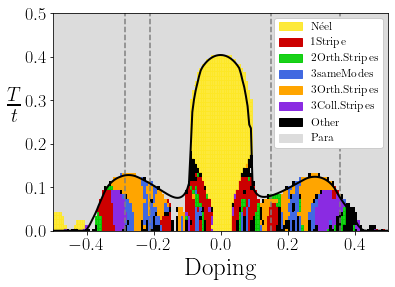

In [28]:
###Our first major plot: The phase diagram of BBG

ColorArrayPlot = np.array(ColorArrayPlot,dtype = float)
for i in [0]:
    print("Atom flavor = ",Atom_Array[i])

    fig = plt.figure()
    ax = plt.subplot(111)
    X,Y = np.meshgrid(np.array(T_Array),np.array(Doping_Array))
    X = np.array(X,dtype = float).transpose()
    Y = np.array(Y,dtype = float).transpose()
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True)
    cm = ax.pcolormesh(Y,X,ColorArrayPlot[:,i,:],vmin=0, vmax=9,shading ="nearest",cmap = cmap2)
    ax.set_xlabel(r"Doping",fontsize = 25)
    ax.set_ylabel(r"$\frac{T}{t}$",fontsize = 28,rotation="horizontal",ha = "right")
    
    ax.vlines(1.-0.849,0.,0.5, color = "grey",linestyle = "dashed")
    ax.vlines(1.-0.6442,0.,0.5, color = "grey",linestyle = "dashed")
    ax.vlines(1.-1.2116,0.,0.5, color = "grey",linestyle = "dashed")
    ax.vlines(1.-1.2864,0.,0.5, color = "grey",linestyle = "dashed")

    values = [2,4,3,6,5,9,0,1]
    colors = [ cm.cmap(cm.norm(value)) for value in values]
    labelArray = [r"N\'eel",r"1Stripe",r"2Orth.Stripes",r"3sameModes",r"3Orth.Stripes","3Coll.Stripes",r"Other",r"Para"]
    patches = [mpatches.Patch(color=colors[i], label=labelArray[i] ) for i in range(len(values)) ]
    legend = ax.legend(handles=patches, bbox_to_anchor=(0.66, 0.98), loc=2, borderaxespad=0.,fontsize = 11.4 )
    legend.get_frame().set_alpha(1.)

    ax.plot(1-n_Crit_Array,T_Crit_Array,"black",linewidth = 2)
    ax.set_xlim(-0.5,0.5)
    ax.set_ylim(0,0.5)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    ###plt.savefig("PhaseDiagram_BBG_2ModesIsStrange_SpiralStrange_2OrthStripes_vanHove_New_CorrectUnits_BigTicks_1Stripe.png",bbox_inches='tight',dpi = 800)
    plt.show()


0.04 0.34722222222222276
3ParallelStripes


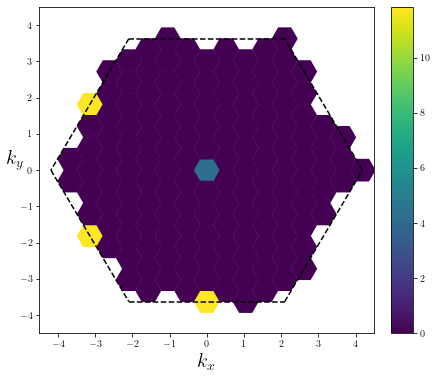

In [34]:
###One can also generate the fourier spectrum of a given GapVector.

i,j,k = 4,0,22
print(T_Array[i],Doping_Array[k])
Gappy = GapVectorArray[i,j,k]
print(ClassArray[i,j,k])

V1,V2,V3 = Classification(Gappy,ReturnVecs=True)

Qs,Components,fig,ax = Plot_BBG.Plotit(Gappy,returnaxes=True,N_x = N_x)

In [37]:
###Here  we determine the avg magnetization of the converged states.

VectorArray = np.zeros((len(T_Array),len(Atom_Array),len(Doping_Array)))
Norm = np.zeros((len(T_Array),len(Atom_Array),len(Doping_Array)))
Norm2 = np.zeros((len(T_Array),len(Atom_Array),len(Doping_Array)))

N_tot = N_x*N_y

for i in range(len(T_Array)):
    for j in range(len(Atom_Array)):
        for k in range(len(Doping_Array)):

            Charge = 1-Doping_Array[k]
            
            
            GapVector = GapVectorArray[i,j,k]
            N_ups = GapVector[:N_tot]
            N_downs = GapVector[N_tot:2*N_tot]
            D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:]
            S_x = (2*np.real(D_UpDowns))
            S_y = (2*np.imag(D_UpDowns))
            S_z = (N_ups-N_downs)

            Charge_local = GapVectorArray[i,j,k][:N_tot] + GapVectorArray[i,j,k][N_tot:2*N_tot]
            Amplitudes = np.sqrt(S_x**2 + S_y**2 +S_z**2)/2
            Norm[i,j,k] = 1./N_tot*np.sum(Amplitudes)
            Norm2[i,j,k] = 1./N_tot*(np.sum(Amplitudes[0::4] + Amplitudes[1::4]-Amplitudes[2::4]-Amplitudes[3::4]))


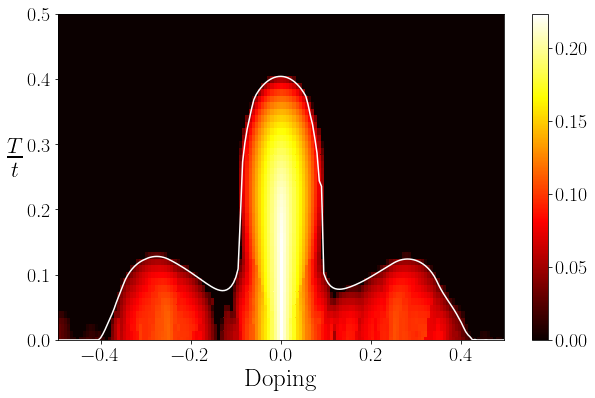

In [45]:
###Our 2nd major plot: The magnetization phase diagram of BBG

fig = plt.figure(figsize = (10,6))
ax = plt.subplot(111)
X,Y = np.meshgrid(np.array(T_Array),np.array(Doping_Array))
X = np.array(X,dtype = float).transpose()
Y = np.array(Y,dtype = float).transpose()

Data = 1./4*(Norm[:,0,:] + Norm[:,1,:] + Norm[:,2,:] + Norm[:,3,:])
cm = ax.pcolormesh(Y,X,Data,shading = "nearest",cmap = "hot",vmin=min(0,np.min((Data))), vmax=np.max(abs(Data)))

ax.set_xlabel(r"Doping",fontsize = 25)
ax.set_ylabel(r"$\frac{T}{t}$",fontsize = 32,rotation="horizontal",ha = "right")
cb = fig.colorbar(cm)

ax.plot(1-n_Crit_Array,T_Crit_Array,"white",linewidth = 1.5)

ax.set_ylim(0.,0.5)
ax.set_xlim(-0.495,0.495)


plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


cb.ax.tick_params(labelsize=20)


plt.show()